In [1]:
!unzip cnn_dataset.zip -d ./

Streaming output truncated to the last 5000 lines.
  inflating: ./cnn_dataset/Y/17105.png  
  inflating: ./cnn_dataset/Y/17130.png  
  inflating: ./cnn_dataset/Y/17137.png  
  inflating: ./cnn_dataset/Y/17143.png  
  inflating: ./cnn_dataset/Y/17149.png  
  inflating: ./cnn_dataset/Y/1721.png  
  inflating: ./cnn_dataset/Y/17222.png  
  inflating: ./cnn_dataset/Y/17252.png  
  inflating: ./cnn_dataset/Y/17304.png  
  inflating: ./cnn_dataset/Y/17315.png  
  inflating: ./cnn_dataset/Y/17316.png  
  inflating: ./cnn_dataset/Y/17321.png  
  inflating: ./cnn_dataset/Y/17359.png  
  inflating: ./cnn_dataset/Y/17366.png  
  inflating: ./cnn_dataset/Y/17372.png  
  inflating: ./cnn_dataset/Y/17374.png  
  inflating: ./cnn_dataset/Y/1738.png  
  inflating: ./cnn_dataset/Y/17413.png  
  inflating: ./cnn_dataset/Y/17430.png  
  inflating: ./cnn_dataset/Y/17458.png  
  inflating: ./cnn_dataset/Y/17475.png  
  inflating: ./cnn_dataset/Y/17493.png  
  inflating: ./cnn_dataset/Y/17566.png  
  inflat

In [4]:
from torchvision import datasets,transforms
import torch

trans=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset=datasets.ImageFolder(root='cnn_dataset',transform=trans)

In [5]:
from torch.utils.data import random_split

train_ds,test_ds=random_split(dataset,[int(0.8*len(dataset)),int(0.2*len(dataset))])
train_ds,val_ds=random_split(train_ds,[int(0.9*len(train_ds)),int(0.1*len(train_ds))])

In [6]:
train_data_loader=torch.utils.data.DataLoader(train_ds,batch_size=64,shuffle=True)
test_data_loader=torch.utils.data.DataLoader(test_ds,batch_size=64,shuffle=True)
val_data_loader=torch.utils.data.DataLoader(val_ds,batch_size=64,shuffle=True)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.nn import functional as F

class Block(nn.Module):
    def __init__(self,in_channel,out_channel,stride=1,downsample=None):
        super(Block,self).__init__()

        self.seqblock=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,kernel_size=3,stride=stride,padding=1,bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel,out_channel,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(out_channel),
        )
        self.downsample=downsample
        self.stride=stride

    def forward(self,x):
        res=x
        out=self.seqblock(x)
        if self.downsample:
            res=self.downsample(x)
        out+=res
        out=F.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self,block,layers=[3,4,6,3],num_classes=36):
        super(ResNet34,self).__init__()
        self.in_channel=64
        self.start=nn.Sequential(
            nn.Conv2d(3,self.in_channel,kernel_size=7,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(self.in_channel),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )

        self.layer1=self._make_layer(block,64,layers[0])
        self.layer2=self._make_layer(block,128,layers[1],stride=2)
        self.layer3=self._make_layer(block,256,layers[2],stride=2)
        self.layer4=self._make_layer(block,512,layers[3],stride=2)
        self.avgpool=nn.AvgPool2d(7,stride=1)
        self.fc=nn.Linear(512,num_classes)

    def _make_layer(self,block,out_channel,blocks,stride=1):
        downsample=None
        if(stride!=1 or self.in_channel!=out_channel):
            downsample=nn.Sequential(
                nn.Conv2d(self.in_channel,out_channel,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channel)
            )
        layers=[]
        layers.append(block(self.in_channel,out_channel,stride,downsample))
        self.in_channel=out_channel
        for i in range(1,blocks):
            layers.append(block(self.in_channel,out_channel))
        return nn.Sequential(*layers)

    def forward(self,x):
        x=self.start(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)

        x=self.avgpool(x)
        x=torch.flatten(x,start_dim=1)
        x=self.fc(x)

        return x


model=ResNet34(Block)

print(model)


ResNet34(
  (start): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Block(
      (seqblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (seqblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [8]:
device = torch.device("cuda")

model.to(device)

ResNet34(
  (start): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Block(
      (seqblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (seqblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [9]:
def accuracy(model,test_data):
  model.eval()
  total=0
  correct=0
  with torch.no_grad():
    for img,label in test_data:
      img,label=img.to(device),label.to(device)
      pred=model(img)
      output=torch.argmax(pred,dim=1)
      total+=label.size(0)
      correct+=(output==label).sum().item()
  acc=(correct/total)*100
  return acc

In [10]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import time
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
scheduler=ExponentialLR(optimizer,gamma=0.6)
val_loss=[]
test_loss=[]
train_loss=[]
val_acc=[]
test_acc=[]
train_acc=[]
for epoch in range(5):
    model.train()
    start_time=time.time()
    traini_loss=0
    for img,label in train_data_loader:
        img,label=img.to(device),label.to(device)
        pred=model(img)
        loss=criterion(pred,label)
        traini_loss+=loss.item()
        predicted_labels = torch.argmax(pred, dim=1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    train_loss.append(traini_loss/len(train_data_loader))
    testi_loss=0
    vali_loss=0
    model.eval()
    with torch.no_grad():
        for img,label in test_data_loader:
          img,label=img.to(device),label.to(device)
          pred=model(img)
          testi_loss+=criterion(pred,label)
        test_loss.append(testi_loss.item()/len(test_data_loader))
        for img,label in val_data_loader:
          img,label=img.to(device),label.to(device)
          pred=model(img)
          vali_loss+=criterion(pred,label)
        val_loss.append(vali_loss.item()/len(val_data_loader))
    test_acc.append(accuracy(model,test_data_loader))
    val_acc.append(accuracy(model,val_data_loader))
    train_acc.append(accuracy(model,train_data_loader))
    end_time=time.time()
    print("For epoch {0}  loss:{1}  test_loss:{2}  val_loss{3}".format(epoch+1,train_loss[-1],test_loss[-1],val_loss[-1]))
    print("Time taken for epoch {0}:{1:.3f}s".format(epoch+1,end_time-start_time))


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


For epoch 1  loss:0.47313946634662424  test_loss:0.3008610074482267  val_loss0.2817188444591704
Time taken for epoch 1:849.995s
For epoch 2  loss:0.24468753505925234  test_loss:0.2515343560112847  val_loss0.2397026334490095
Time taken for epoch 2:851.289s
For epoch 3  loss:0.20874182526777765  test_loss:0.21001654730902777  val_loss0.2011194834633479
Time taken for epoch 3:852.990s
For epoch 4  loss:0.18443952868750066  test_loss:0.20883590456039186  val_loss0.2023475889175657
Time taken for epoch 4:856.167s
For epoch 5  loss:0.16566251663776932  test_loss:0.200291261218843  val_loss0.19391046251569474
Time taken for epoch 5:857.902s


In [25]:
torch.save(model.state_dict(),"./gsubrama_ksoundap_assignment2_bonus.pth")

In [13]:
print(accuracy(model,test_data_loader))

92.36111111111111


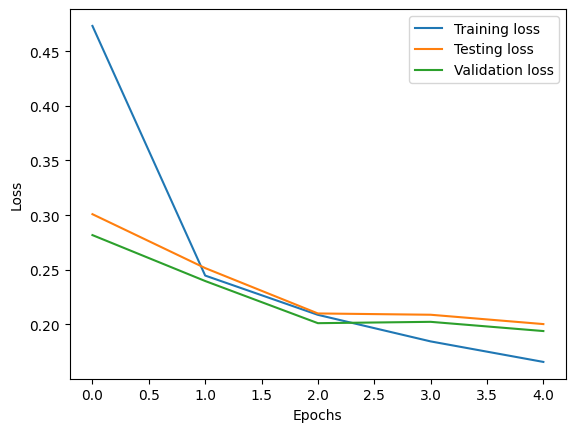

In [16]:
import matplotlib.pyplot as plt

x=range(5)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x,train_loss)
plt.plot(x,test_loss)
plt.plot(x,val_loss)
plt.legend(['Training loss','Testing loss','Validation loss'])

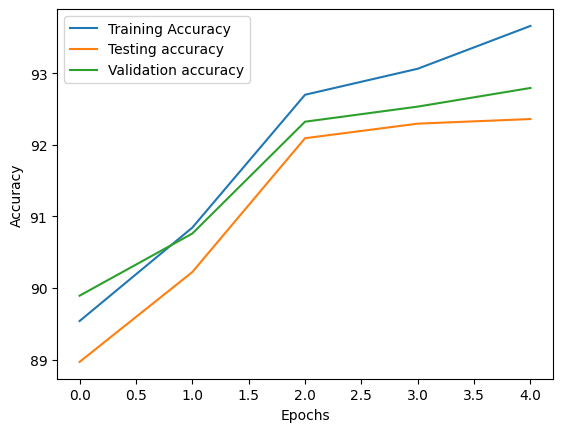

In [17]:
x=range(5)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(x,train_acc)
plt.plot(x,test_acc)
plt.plot(x,val_acc)
plt.legend(['Training Accuracy','Testing accuracy','Validation accuracy'])

In [18]:
import numpy as np
true_labels=np.array([])
pred_labels=np.array([])
pred_prob=np.array([])
with torch.no_grad():
  for img,labels in test_data_loader:
    img,labels=img.to(device),labels.to(device)
    pred=model(img)
    pred_prob=np.append(pred_prob,pred.cpu().numpy())
    output=torch.argmax(pred,dim=1)
    true_labels=np.append(true_labels,labels.cpu().numpy())
    pred_labels=np.append(pred_labels,output.cpu().numpy())



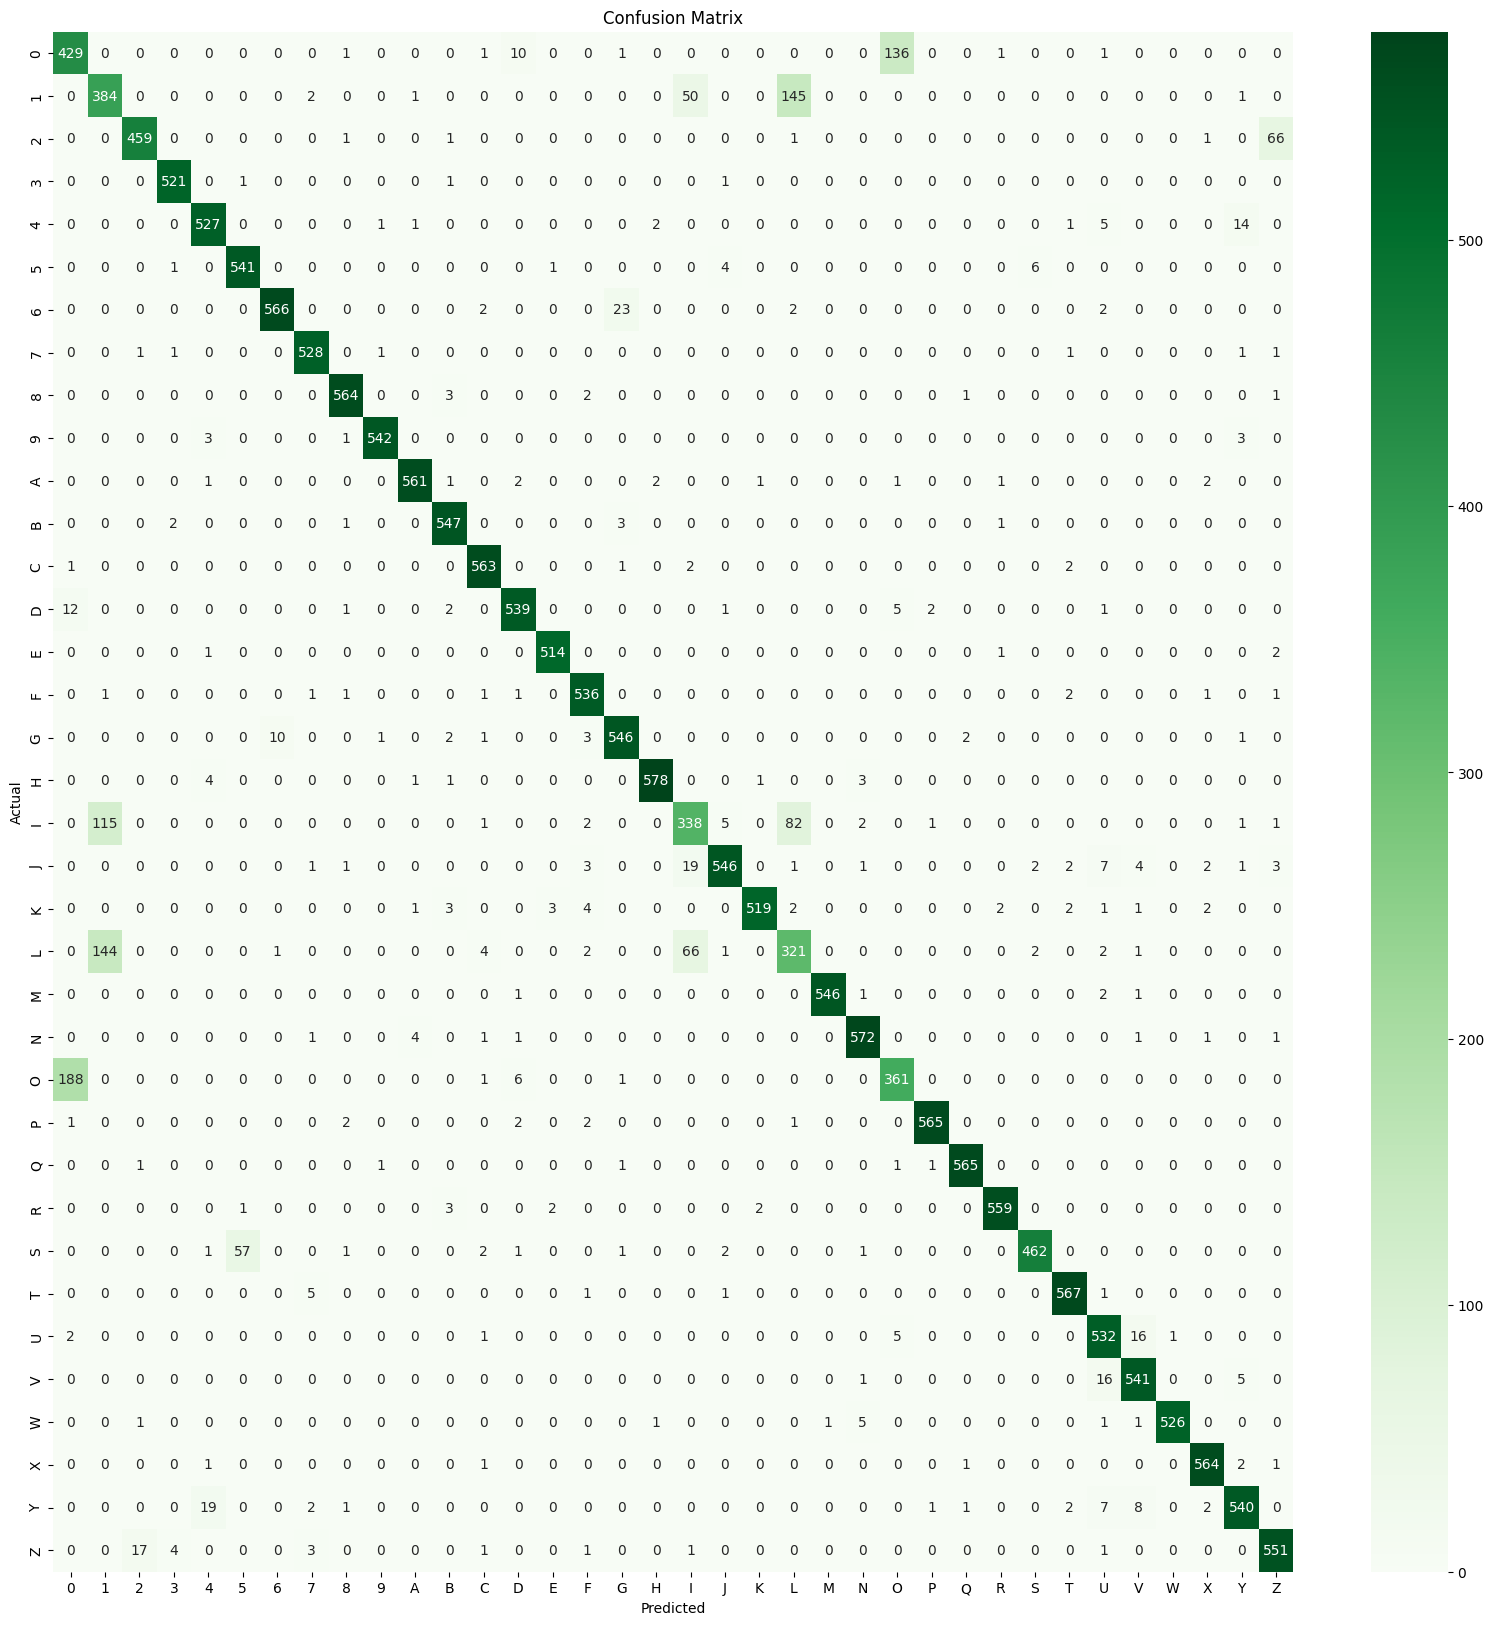

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes=(0,1,2,3,4,5,6,7,8,9,'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z')
confusion_mat = confusion_matrix(true_labels,pred_labels)
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_mat, annot=True,fmt='d',cmap="Greens",xticklabels=classes,yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
from sklearn.metrics import precision_recall_fscore_support

prec,recall,f_score,support=precision_recall_fscore_support(true_labels,pred_labels,average='micro')
print("Precision obtained in test dataset:{0:.2f}".format(prec))
print("Recall obtained in test dataset:{0:.2f}".format(recall))
print("F_score obtained in test dataset:{0:.2f}".format(f_score))
print("Support obtained in test dataset:{0}".format(support))

Precision obtained in test dataset:0.92
Recall obtained in test dataset:0.92
F_score obtained in test dataset:0.92
Support obtained in test dataset:None


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.1 MB/s eta 0:00:00


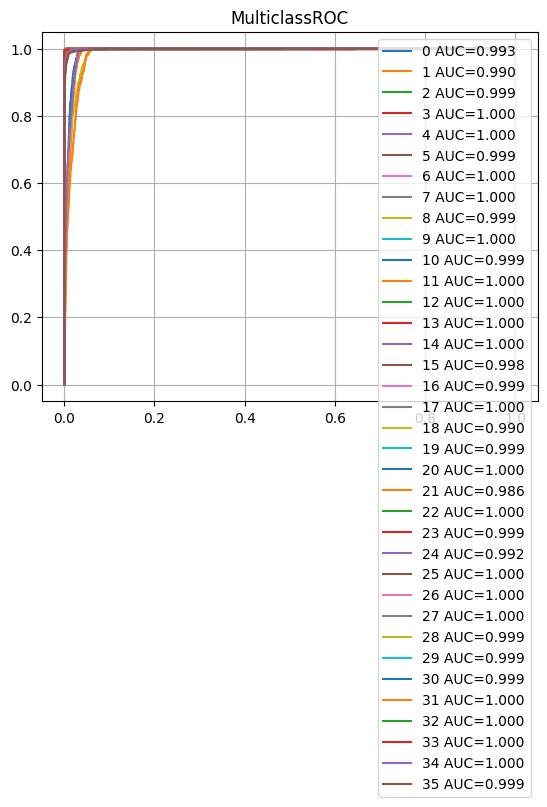

In [24]:
!pip install torchmetrics
from torchmetrics.classification import MulticlassROC


pred_prob=np.reshape(pred_prob,newshape=(len(test_data_loader)*64,36))
pred_prob_tensor=torch.tensor(pred_prob)
true_labels_tensor=torch.tensor(true_labels,dtype=torch.long)

metric=MulticlassROC(num_classes=36)
metric.update(pred_prob_tensor,true_labels_tensor)
fig_, ax_ = metric.plot(score=True)
